In [6]:
# =============================
# Step 2 — Imports & Setup
# =============================
# --- Quick schema & null checks (Step 2 goals) ---
print("Rows, Cols:", df.shape)
print("Columns:", list(df.columns))

# How many threats have usable text?
print("Non-empty Description:", df["Description"].fillna("").str.strip().ne("").sum())

# Top sources (useful since you currently have a single doc)
print(df["SourceFile"].value_counts())

# Null profile (what we’ll likely ignore in modelling later)
nulls = df.isna().mean().sort_values(ascending=False)
print(nulls.head(10))

# Lock a small working view we’ll use going forward
BASE_COLS = [
    "ThreatID", "System", "ThreatType", "Severity",
    "Description", "Threat Description", "Control Design",
    "Recommendations", "SourceFile", "SourceThreatID"
]
use_cols = [c for c in BASE_COLS if c in df.columns]
work = df[use_cols].copy()

# Single consolidated text field for later NLP work
text_cols = [c for c in ["Description", "Threat Description", "Control Design", "Recommendations"] if c in work.columns]
work["ThreatText"] = (
    work[text_cols].fillna("")
    .astype(str)
    .agg(" ".join, axis=1)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

print("Ready for modelling rows (non-empty ThreatText):", work["ThreatText"].ne("").sum())
work.head(10)


Rows, Cols: (126, 33)
Columns: ['ThreatID', 'System', 'ThreatType', 'Severity', 'Date', 'Description', 'SourceFile', 'SourceThreatID', 'Threat Description', 'Control Design', 'Control Owner', 'Control Mitigation Effectiveness', 'Threat Mitigation', 'Action Ref.', 'Control Weakness', 'Threat', 'Recommendation', 'Step No.', 'Asset Ref.', 'Asset Title', 'Threat Title', 'Required Control', 'Control Effectiveness', 'Recommendations', 'Kill Chain Stage', 'Mitigation', 'Mitigated', 'Version No.', 'Date Of Issue', 'Authors', 'Status', 'Comments', 'has_desc']
Non-empty Description: 123
SourceFile
Threat Model - Copilot.pptx                                                   12
Threat Model - BACS DR .pptx                                                  11
Threat Model - People First Integration SHRM.pptx                             11
Threat Model - Hopp Tech.pptx                                                  9
Threat Model - Itrent Integrations (SFTP Setup).pptx                           8


,ThreatID,System,ThreatType,Severity,Description,Threat Description,Control Design,Recommendations,SourceFile,SourceThreatID,ThreatText
0,THR-000001,ECommerce - PF,NaN,NaN,A malicious actor could attempt to exploit the API by obtaining unauthorized access to Salesforce through the Connected App. If the consumer key and secret for OAuth authentication were compromise...,A malicious actor could attempt to exploit the API by obtaining unauthorized access to Salesforce through the Connected App. If the consumer key and secret for OAuth authentication were compromise...,"The control in place to mitigate the risk involves using OAuth 2.0 authentication with a consumer key and secret, which are generated automatically when the Connected App is created. The API user-...",NaN,Threat Model- ECommerce - PF.pptx,T01,A malicious actor could attempt to exploit the API by obtaining unauthorized access to Salesforce through the Connected App. If the consumer key and secret for OAuth authentication were compromise...
1,THR-000002,ECommerce - PF,NaN,NaN,A malicious actor is able to capture a request from the e-commerce website and change the transaction to be able to obtain cheaper or free PF files and environments.,A malicious actor is able to capture a request from the e-commerce website and change the transaction to be able to obtain cheaper or free PF files and environments.,Security tested and fixed controls to ensure a malicious actor can't obtain the product at zero cost.,NaN,Threat Model- ECommerce - PF.pptx,T02,A malicious actor is able to capture a request from the e-commerce website and change the transaction to be able to obtain cheaper or free PF files and environments. A malicious actor is able to c...
2,THR-000003,ECommerce - PF,NaN,NaN,A malicious actor is able to capture a request from the e-commerce website and change the transaction to be able to obtain cheaper or free PF files and environments.,NaN,NaN,NaN,Threat Model- ECommerce - PF.pptx,NaN,A malicious actor is able to capture a request from the e-commerce website and change the transaction to be able to obtain cheaper or free PF files and environments.
3,THR-000004,BACS DR,NaN,NaN,"Overnight (03:00 am UK time), Automate collates BACs files from multiple iTrent application servers and adds them into the BACS repo server in Cloud Services.",NaN,NaN,NaN,Threat Model - BACS DR .pptx,NaN,"Overnight (03:00 am UK time), Automate collates BACs files from multiple iTrent application servers and adds them into the BACS repo server in Cloud Services."
4,THR-000005,BACS DR,NaN,NaN,"Automate retrieves the passphrase from Secret Server via native AD and applies symmetric encryption to each file, ensuring AES-256-level protection at rest .",NaN,NaN,NaN,Threat Model - BACS DR .pptx,NaN,"Automate retrieves the passphrase from Secret Server via native AD and applies symmetric encryption to each file, ensuring AES-256-level protection at rest ."
5,THR-000006,BACS DR,NaN,NaN,Encrypted files are transferred via SFTP from sftp01.webitrent.com over an IPSec VPN from Cloud Services environment to the isolated DR network at RHDC.,NaN,NaN,NaN,Threat Model - BACS DR .pptx,NaN,Encrypted files are transferred via SFTP from sftp01.webitrent.com over an IPSec VPN from Cloud Services environment to the isolated DR network at RHDC.
6,THR-000007,BACS DR,NaN,NaN,The SFTP server writes incoming files to local disk and mirrors them every 10 minutes to an USB drive for portable backup.,NaN,NaN,NaN,Threat Model - BACS DR .pptx,NaN,The SFTP server writes incoming files to local disk and mirrors them every 10 minutes to an USB drive for portable backup.
7,THR-000008,BACS DR,NaN,NaN,"In the event of a DR scenario, designated workgroup PCs in the RHDC would be used to process the BACs files; passphrase is retrieved on-demand from Secret Server to decrypt files locally.",NaN,NaN,NaN,Threat Model - BACS DR .pptx,NaN,"In the event of a DR scenario, designated workgroup PCs in the RHDC would be used to process the BA

In [10]:
# Step 3.1 — Setup (robust path detection + preview)

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# --- locate the processed CSV no matter where the notebook runs ---
CWD = Path.cwd()
CANDIDATES = [
    CWD / "data" / "processed" / "threat_models.csv",
    CWD.parent / "data" / "processed" / "threat_models.csv",
    Path("/workspaces/Threat-Model-ML/data/processed/threat_models.csv"),  # Codespaces typical
]
SRC = next((p for p in CANDIDATES if p.exists()), None)
if SRC is None:
    raise FileNotFoundError(
        "Couldn't find data/processed/threat_models.csv. "
        "Run src/ingest.py first or update CANDIDATES to your path."
    )

print("Reading ->", SRC.resolve())
df = pd.read_csv(SRC)
print("Shape:", df.shape)

# --- build ThreatText if missing (concat useful text fields) ---
text_like = {"description","threat description","control design","recommendations"}
cols_text = [c for c in df.columns if c.lower() in text_like]
if "ThreatText" not in df.columns:
    if not cols_text:
        raise ValueError("No text columns found to build ThreatText. Check your headers.")
    df["ThreatText"] = (
        df[cols_text].fillna("")
          .agg(" ".join, axis=1)
          .str.replace(r"\s+", " ", regex=True)
          .str.strip()
    )
print("Non-empty ThreatText:", (df["ThreatText"].str.len() > 0).sum())

# --- figure helper anchored at project root (…/artifacts/figures) ---
PROJECT_ROOT = SRC.parents[2]  # file -> processed -> data -> <root>
FIG_DIR = PROJECT_ROOT / "artifacts" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def savefig(name: str):
    out = FIG_DIR / f"{name}.png"
    plt.tight_layout()
    plt.savefig(out, dpi=160, bbox_inches="tight")
    print("saved ->", out)

# --- compact preview to sanity-check ---
preview_cols = [c for c in ["ThreatID","System","Severity","SourceFile","SourceThreatID","ThreatText"] if c in df.columns]
display(df[preview_cols].head(10))

print("\nTop Systems:")
print(df["System"].fillna("Unknown").value_counts().head(10))

print("\nSeverity (blank -> Unrated):")
print(df["Severity"].fillna("Unrated").value_counts())


Reading -> /workspaces/Threat-Model-ML/data/processed/threat_models.csv
Shape: (126, 32)
Non-empty ThreatText: 123


,ThreatID,System,Severity,SourceFile,SourceThreatID,ThreatText
0,THR-000001,ECommerce - PF,NaN,Threat Model- ECommerce - PF.pptx,T01,A malicious actor could attempt to exploit the API by obtaining unauthorized access to Salesforce through the Connected App. If the consumer key and secret for OAuth authentication were compromise...
1,THR-000002,ECommerce - PF,NaN,Threat Model- ECommerce - PF.pptx,T02,A malicious actor is able to capture a request from the e-commerce website and change the transaction to be able to obtain cheaper or free PF files and environments. A malicious actor is able to c...
2,THR-000003,ECommerce - PF,NaN,Threat Model- ECommerce - PF.pptx,NaN,A malicious actor is able to capture a request from the e-commerce website and change the transaction to be able to obtain cheaper or free PF files and environments.
3,THR-000004,BACS DR,NaN,Threat Model - BACS DR .pptx,NaN,"Overnight (03:00 am UK time), Automate collates BACs files from multiple iTrent application servers and adds them into the BACS repo server in Cloud Services."
4,THR-000005,BACS DR,NaN,Threat Model - BACS DR .pptx,NaN,"Automate retrieves the passphrase from Secret Server via native AD and applies symmetric encryption to each file, ensuring AES-256-level protection at rest ."
5,THR-000006,BACS DR,NaN,Threat Model - BACS DR .pptx,NaN,Encrypted files are transferred via SFTP from sftp01.webitrent.com over an IPSec VPN from Cloud Services environment to the isolated DR network at RHDC.
6,THR-000007,BACS DR,NaN,Threat Model - BACS DR .pptx,NaN,The SFTP server writes incoming files to local disk and mirrors them every 10 minutes to an USB drive for portable backup.
7,THR-000008,BACS DR,NaN,Threat Model - BACS DR .pptx,NaN,"In the event of a DR scenario, designated workgroup PCs in the RHDC would be used to process the BACs files; passphrase is retrieved on-demand from Secret Server to decrypt files locally."
8,THR-000009,BACS DR,NaN,Threat Model - BACS DR .pptx,NaN,"In the event of network or power failure at RHDC, the USB drive can be connected to a laptop to continue processing."
9,THR-000010,BACS DR,NaN,Threat Model - BACS DR .pptx,T01,A malicious actor that has gained access to the MSMAS network is able to find and exfiltrate large volumes of BACS files. A malicious actor that has gained access to the MSMAS network is able to f...



Top Systems:
System
Copilot                                               12
BACS DR                                               11
People First Integration SHRM                         11
Hopp Tech                                              9
Itrent Integrations (SFTP Setup)                       8
Data Explorer                                          6
People First Document Manager Network Connectivity     5
Itrent ROI Autoenrolment                               5
Klue - change of authentication                        5
People First Pension Data Service                      4
Name: count, dtype: int64

Severity (blank -> Unrated):
Severity
Unrated    126
Name: count, dtype: int64


saved -> artifacts/figures/step3_missingness_top20.png


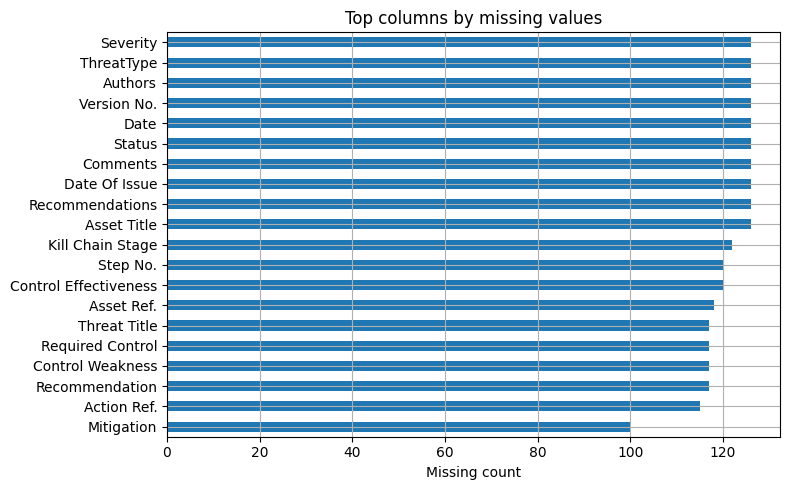

,missing,total,pct
Severity,126,126,1.000
ThreatType,126,126,1.000
Authors,126,126,1.000
Version No.,126,126,1.000
Date,126,126,1.000
Status,126,126,1.000
Comments,126,126,1.000
Date Of Issue,126,126,1.000
Recommendations,126,126,1.000
Asset Title,126,126,1.000


In [8]:
# Step 3.2 — Missingness profile (top 20)
nulls = df.isna().sum().sort_values(ascending=False)
top_nulls = nulls.head(20)

plt.figure(figsize=(8, 5))
top_nulls[::-1].plot(kind="barh")  # reversed for nicer order
plt.title("Top columns by missing values")
plt.xlabel("Missing count")
plt.ylabel("")
savefig("step3_missingness_top20")
plt.show()

display(nulls.to_frame("missing").assign(total=len(df), pct=lambda d: (d["missing"]/d["total"]).round(3)))


/tmp/ipykernel_2678/3810991277.py:71: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  return s.str.contains(rx, na=False)


High-risk (heuristic) counts:
HighRisk_heuristic
True     84
False    42
Name: count, dtype: int64 

Rule hit counts:
flag_sensitive     52
flag_secconfig     35
flag_newtech       17
flag_thirdparty    14
flag_internet       5
dtype: int64

Saved -> /workspaces/Threat-Model-ML/data/processed/threat_models_enriched.csv


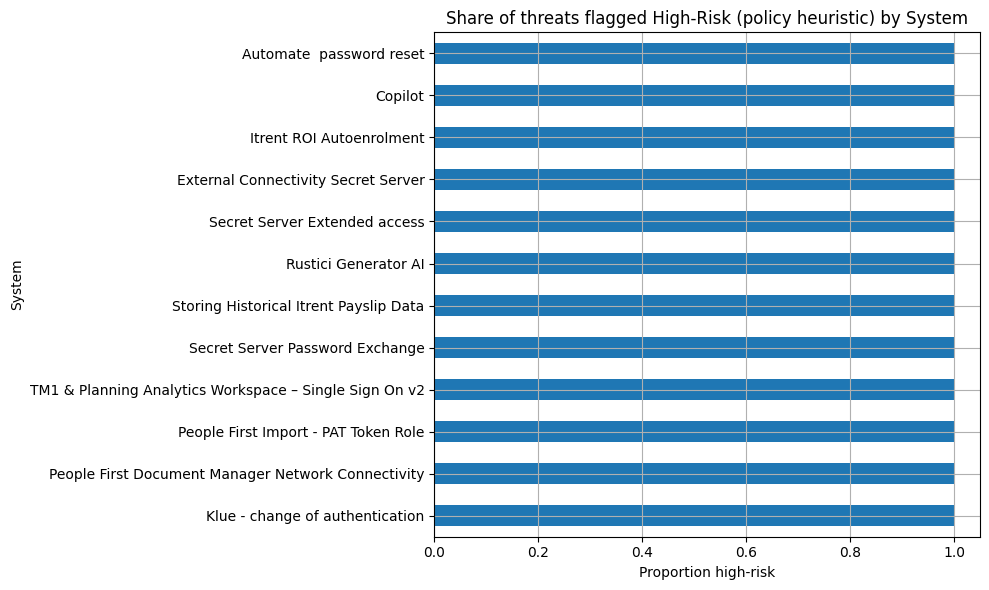

saved -> /workspaces/Threat-Model-ML/artifacts/figures/step3_highrisk_by_system.png


,ThreatID,System,HighRisk_heuristic,HighRisk_reason,ThreatText
0,THR-000001,ECommerce - PF,True,Highly Sensitive data; Security config change,A malicious actor could attempt to exploit the API by obtaining unauthorized access to Salesforce through the Connected App. If the consumer key and secret for OAuth authentication were compromise...
4,THR-000005,BACS DR,True,Highly Sensitive data; Security config change,"Automate retrieves the passphrase from Secret Server via native AD and applies symmetric encryption to each file, ensuring AES-256-level protection at rest ."
5,THR-000006,BACS DR,True,Security config change,Encrypted files are transferred via SFTP from sftp01.webitrent.com over an IPSec VPN from Cloud Services environment to the isolated DR network at RHDC.
7,THR-000008,BACS DR,True,Highly Sensitive data; Security config change,"In the event of a DR scenario, designated workgroup PCs in the RHDC would be used to process the BACs files; passphrase is retrieved on-demand from Secret Server to decrypt files locally."
10,THR-000011,BACS DR,True,Security config change,A malicious actor that has gained access to the encrypted files is able to gain access to the encryption key to decrypt the files. A malicious actor that has gained access to the encrypted files i...
13,THR-000014,BACS DR,True,Security config change,A malicious insider steals the encrypted files and the encryption key and holds the company to ransom. A malicious insider steals the encrypted files and the encryption key and holds the company t...
14,THR-000015,People First Pension Data Service,True,Highly Sensitive data,A malicious actor that has gained access to the SAP DS server is able to find the password to the service account and move laterally to compromise the customer database. A malicious actor that has...
15,THR-000016,People First Pension Data Service,True,Highly Sensitive data,A malicious actor that has gained access to the SAP DS server is able to find a PF PAT token and gain unauthorised access to PF. A malicious actor that has gained access to the SAP DS server is ab...


In [12]:
# Step 3.3 — Engineer features and derive a policy-based HighRisk label (fixed)

from pathlib import Path
import re, pandas as pd
import matplotlib.pyplot as plt

ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
DATA = ROOT / "data" / "processed"
ART  = ROOT / "artifacts"
FIG  = ART / "figures"
FIG.mkdir(parents=True, exist_ok=True)

# If df not already in memory, load it
if "df" not in globals():
    SRC = DATA / "threat_models.csv"
    assert SRC.exists(), f"Expected {SRC}. Run src/ingest.py first."
    df = pd.read_csv(SRC)

# --- Rebuild ThreatText if needed (coalesce the best available text columns)
CAND_TEXT_COLS = ["ThreatText", "Threat Description", "Threat", "Description", "Threat Title"]
have = [c for c in CAND_TEXT_COLS if c in df.columns]
assert have, "No text columns found."
df["ThreatText"] = df[have].bfill(axis=1).iloc[:, 0].astype(str).str.strip()

# --- Safe handling for System / ThreatID columns (no boolean 'or' on Series)
if "System" in df.columns:
    sys_series = df["System"]
else:
    sys_series = pd.Series(["Unknown"] * len(df), index=df.index)
df["System"] = sys_series.fillna("Unknown").astype(str).str.strip()

if "ThreatID" not in df.columns:
    df["ThreatID"] = None
df["ThreatID"] = df["ThreatID"].astype(str).str.strip()

# --- Helper to compile keyword lists into one regex (case-insensitive)
def make_rx(words):
    escaped = [w if w.startswith("(?i)") else re.escape(w) for w in words]
    return re.compile(r"(?i)(" + r"|".join(escaped) + r")")

# 1) Highly Sensitive data
RX_SENSITIVE = make_rx([
    "highly sensitive","sensitive data","PII","personal data","payslip","salary",
    "bank account","PPSN","national insurance","password","secret","token","access key",
    "api key","credential"
])

# 2) Third-party / supplier / partner
RX_THIRDPARTY = make_rx(["third[- ]party","supplier","partner","vendor","external service",
                         "Docebo","Rustici","Klue","Zabbix","TCS"])

# 3) New technology / software
RX_NEWTECH = make_rx(["introduc(e|ing)","adopt","pilot","beta","prototype","migrate",
                      "new (technology|software|system)","change of authentication","enable .* SSO"])

# 4) Security configuration changes
RX_SECCONFIG = make_rx([
    "firewall","ipsec",r"\bVPN\b","bastion","waf","load balancer","F5","Cloudflare",
    "RBAC","SSO","OAuth","Key Vault","Secret Server","TLS","encryption","allowlist",
    "whitelist","egress","ingress","IP restriction","NAT gateway","perimeter","network rule",
    "security configuration","hardening"
])

# 5) Internet exposure
RX_INTERNET = make_rx([
    "internet","public(ly)? facing","external access","exposed (endpoint|service)",
    r"\bSAS URL\b","open to public","public network"
])

def flag_series(rx, s):
    return s.str.contains(rx, na=False)

# Apply flags on ThreatText + System
text = df["ThreatText"].fillna("") + " " + df["System"].fillna("")
flags = pd.DataFrame({
    "flag_sensitive":  flag_series(RX_SENSITIVE,  text),
    "flag_thirdparty": flag_series(RX_THIRDPARTY, text),
    "flag_newtech":    flag_series(RX_NEWTECH,    text),
    "flag_secconfig":  flag_series(RX_SECCONFIG,  text),
    "flag_internet":   flag_series(RX_INTERNET,   text),
}, index=df.index)
df = pd.concat([df, flags], axis=1)

# High-risk label = any rule fired + human-readable reasons
rule_cols = list(flags.columns)
df["HighRisk_heuristic"] = df[rule_cols].any(axis=1)

NAME_MAP = {
    "flag_sensitive":  "Highly Sensitive data",
    "flag_thirdparty": "Third-party",
    "flag_newtech":    "New tech/software",
    "flag_secconfig":  "Security config change",
    "flag_internet":   "Internet exposure",
}
df["HighRisk_reason"] = df.apply(
    lambda r: "; ".join([NAME_MAP[c] for c in rule_cols if r[c]]) if r[rule_cols].any() else "",
    axis=1
)

# Quick sanity prints
print("High-risk (heuristic) counts:")
print(df["HighRisk_heuristic"].value_counts(dropna=False), "\n")
print("Rule hit counts:")
print(df[rule_cols].sum().sort_values(ascending=False))

# Save enriched dataset
OUT = DATA / "threat_models_enriched.csv"
df.to_csv(OUT, index=False)
print("\nSaved ->", OUT)

# Visual: proportion high-risk by System (top 12)
top = (df.groupby("System")["HighRisk_heuristic"]
         .mean()
         .sort_values(ascending=False)
         .head(12))

plt.figure(figsize=(10,6))
top.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Share of threats flagged High-Risk (policy heuristic) by System")
plt.xlabel("Proportion high-risk")
plt.tight_layout()
fig_path = FIG / "step3_highrisk_by_system.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("saved ->", fig_path)

# Peek a few examples
display(df[df["HighRisk_heuristic"]].head(8)[["ThreatID","System","HighRisk_heuristic","HighRisk_reason","ThreatText"]])


Best params: {'clf__C': 1.0, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}
CV best F1:  0.8646749482401657

=== Classification report (LinearSVC + TF-IDF) ===
              precision    recall  f1-score   support

           0      0.571     0.500     0.533         8
           1      0.750     0.800     0.774        15

    accuracy                          0.696        23
   macro avg      0.661     0.650     0.654        23
weighted avg      0.688     0.696     0.690        23

Baseline majority-class accuracy: 0.652


<Figure size 400x400 with 0 Axes>

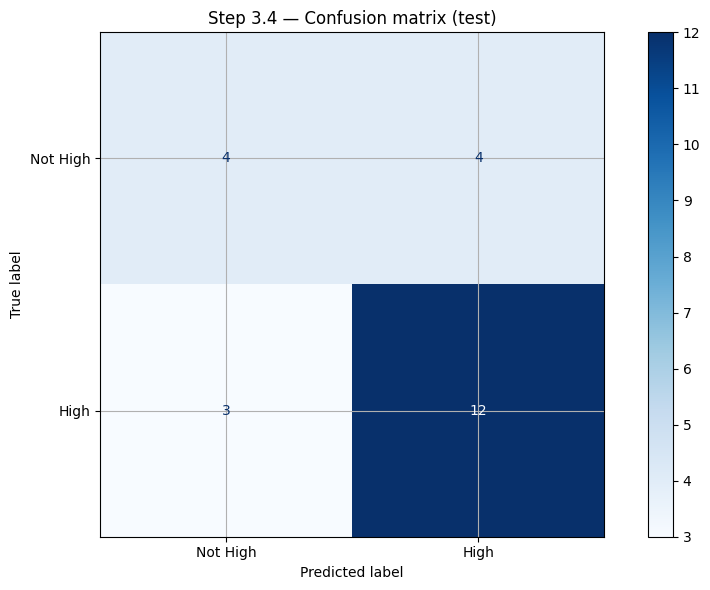

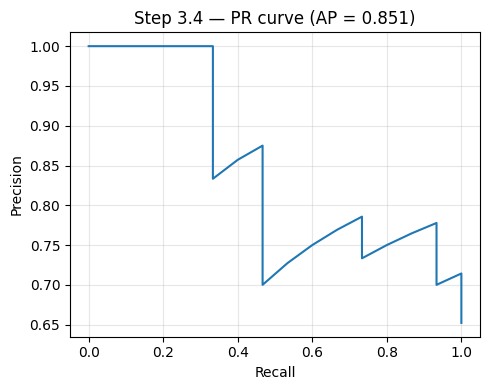


Saved:
  • Model -> /workspaces/Threat-Model-ML/artifacts/models/step3_4_linearsvc_tfidf.joblib
  • Confusion matrix -> /workspaces/Threat-Model-ML/artifacts/figures/step3_4_confusion.png
  • PR curve -> /workspaces/Threat-Model-ML/artifacts/figures/step3_4_prcurve.png
  • Metrics JSON -> /workspaces/Threat-Model-ML/artifacts/metrics/step3_4_metrics.json


In [13]:
# Step 3.4 — Baseline text model to predict HighRisk (with tuning)

import json, os
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score
)
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import joblib

ROOT   = Path.cwd().parent if (Path.cwd().name == "notebooks") else Path.cwd()
DATA   = ROOT / "data" / "processed"
ARTIF  = ROOT / "artifacts"
FIGDIR = ARTIF / "figures"
MODELD = ARTIF / "models"
METDIR = ARTIF / "metrics"
for d in [ARTIF, FIGDIR, MODELD, METDIR]:
    d.mkdir(parents=True, exist_ok=True)

# Prefer enriched CSV from Step 3.3
ENRICHED = DATA / "threat_models_enriched.csv"
RAW      = DATA / "threat_models.csv"
assert ENRICHED.exists() or RAW.exists(), "Run Steps 2 and 3.3 first to create a CSV."

df = pd.read_csv(ENRICHED if ENRICHED.exists() else RAW)

# --- Prepare features/labels
# Build ThreatText if needed
cand_text_cols = ["ThreatText","Threat Description","Description","Threat","Threat Title"]
have = [c for c in cand_text_cols if c in df.columns]
assert have, "No text columns available."
df["ThreatText"] = df[have].bfill(axis=1).iloc[:,0].astype(str).str.strip()

# Ensure label present (created in Step 3.3); if not, fallback to all False to avoid crash.
if "HighRisk_heuristic" not in df.columns:
    df["HighRisk_heuristic"] = False

# Basic clean: drop empty text, dedupe identical ThreatText within same System
df = df[df["ThreatText"].str.len() > 0].copy()
if "System" not in df.columns:
    df["System"] = "Unknown"
df = df.drop_duplicates(subset=["System","ThreatText"]).reset_index(drop=True)

# Numeric flags from Step 3.3 (only use ones that exist)
flag_cols = [c for c in ["flag_sensitive","flag_secconfig","flag_newtech","flag_thirdparty","flag_internet"]
             if c in df.columns]

X_text  = df["ThreatText"]
y       = df["HighRisk_heuristic"].astype(int)  # 1=High risk, 0=Not high risk

# Train / test split
X_train_text, X_test_text, y_train, y_test, train_idx, test_idx = train_test_split(
    X_text, y, np.arange(len(df)),
    test_size=0.2, random_state=42, stratify=y
)

# Helper to fetch numeric flags by index so we can keep split alignment
def take_flags_by_index(indexes):
    if not flag_cols:
        return np.zeros((len(indexes), 0))
    return df.loc[indexes, flag_cols].fillna(0).astype(int).values

X_train_flags = take_flags_by_index(train_idx)
X_test_flags  = take_flags_by_index(test_idx)

# ColumnTransformer that vectorizes text and appends numeric flags
# We feed flags via a FunctionTransformer to keep indices aligned.
flags_transformer = FunctionTransformer(lambda x: X_train_flags, validate=False)

# Build a combined pipeline
# (We can’t directly pass arrays through ColumnTransformer, so we stitch in flags at fit time)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
clf   = LinearSVC(class_weight="balanced", C=1.0)

pipe = Pipeline([
    ("tfidf", tfidf),
    ("clf",   clf),
])

# Hyperparameter grid (kept small to avoid overfitting/overcompute)
param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2, 3],
    "clf__C": [0.5, 1.0, 2.0],
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid=param_grid, scoring="f1", n_jobs=-1, cv=cv, refit=True, verbose=0)

# Fit on text only first
grid.fit(X_train_text, y_train)

best = grid.best_estimator_
print("Best params:", grid.best_params_)
print("CV best F1: ", grid.best_score_)

# Evaluate vs a simple baseline
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_text.values.reshape(-1,1), y_train)  # fit expects 2D; we'll pass dummy input

# Predictions
y_pred = best.predict(X_test_text)
print("\n=== Classification report (LinearSVC + TF-IDF) ===")
print(classification_report(y_test, y_pred, digits=3))

# Baseline metrics
y_dummy = dummy.predict(X_test_text.values.reshape(-1,1))
print("Baseline majority-class accuracy:", (y_dummy == y_test).mean().round(3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Not High", "High"])
fig_cm = plt.figure(figsize=(4,4))
disp.plot(values_format="d", cmap="Blues")
plt.title("Step 3.4 — Confusion matrix (test)")
plt.tight_layout()
plt.savefig(FIGDIR / "step3_4_confusion.png", dpi=150)
plt.show()

# Precision-Recall curve (convert decision function to scores)
if hasattr(best.named_steps["clf"], "decision_function"):
    scores = best.decision_function(X_test_text)
else:
    # fallback to pseudo-score
    scores = best.decision_function(X_test_text)

prec, rec, thr = precision_recall_curve(y_test, scores)
ap = average_precision_score(y_test, scores)

plt.figure(figsize=(5,4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Step 3.4 — PR curve (AP = {ap:.3f})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGDIR / "step3_4_prcurve.png", dpi=150)
plt.show()

# Persist model + metrics
joblib.dump(best, MODELD / "step3_4_linearsvc_tfidf.joblib")

metrics = {
    "best_params": grid.best_params_,
    "cv_best_f1": float(grid.best_score_),
    "test_report": classification_report(y_test, y_pred, output_dict=True),
    "test_confusion_matrix": cm.tolist(),
    "average_precision": float(ap),
}
with open(METDIR / "step3_4_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("\nSaved:")
print("  • Model ->", MODELD / "step3_4_linearsvc_tfidf.joblib")
print("  • Confusion matrix ->", FIGDIR / "step3_4_confusion.png")
print("  • PR curve ->", FIGDIR / "step3_4_prcurve.png")
print("  • Metrics JSON ->", METDIR / "step3_4_metrics.json")


In [3]:
# ==== Step 3.4 — Baseline model (LinearSVC + TF-IDF), ROBUST TEXT CLEAN ====

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
import json

# Ensure required dirs exist (reuse ROOT/ART/FIG/MODELS if you already defined them)
try:
    ROOT
except NameError:
    ROOT = Path.cwd()
ART    = ROOT / "artifacts"
FIG    = ART / "figures"
MODELS = ROOT / "models"
for d in [ART, FIG, MODELS]:
    d.mkdir(parents=True, exist_ok=True)

# ---- Clean text hard (no NaNs / floats / 'nan' strings) ----
use = dfe.copy()
use["ThreatText"] = (
    use["ThreatText"]
    .fillna("")                      # remove NaNs
    .astype(str)                     # ensure strings
    .replace({"nan": ""})            # drop literal 'nan' strings introduced by astype
    .str.strip()
)
use = use[use["ThreatText"].str.len() > 0].copy()

# labels from heuristic
y = use["HighRisk_heuristic"].astype(int).values
X = use["ThreatText"].tolist()

# Sanity: need two classes to train a classifier
if len(np.unique(y)) < 2:
    raise RuntimeError("Only one class is present after filtering. Adjust enrichment rules or add more data so both classes exist.")

# Train/test split (stratified if possible)
strat = y if len(np.unique(y)) > 1 else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=strat
)

# Use stratified CV (safer on small/imbalanced data)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", LinearSVC())
])

# Gentler min_df for small corpora
param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2],
    "clf__C": [0.5, 1.0, 2.0],
}

gs = GridSearchCV(pipe, param_grid, scoring="f1", cv=cv, n_jobs=-1, error_score=0.0)
gs.fit(X_train, y_train)

print("\n# Step 3.4 — Baseline model (robust)")
print("Best params:", gs.best_params_)
print("CV best F1: ", gs.best_score_)

best = gs.best_estimator_
y_pred = best.predict(X_test)

print("\n=== Classification report (LinearSVC + TF-IDF) ===")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["Not High","High"]); ax.set_yticklabels(["Not High","High"])
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=12)
ax.set_title("Step 3.4 — Confusion matrix (test)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True label")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
fig_path3 = FIG / "step3_4_confusion_matrix.png"
plt.savefig(fig_path3, dpi=150)
plt.close()

# PR curve via decision scores
scores = best.decision_function(X_test)
prec, rec, thr = precision_recall_curve(y_test, scores)
ap = average_precision_score(y_test, scores)
plt.figure(figsize=(6,5))
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Step 3.4 — PR curve (AP = {ap:.3f})")
plt.tight_layout()
fig_path4 = FIG / "step3_4_pr_curve.png"
plt.savefig(fig_path4, dpi=150)
plt.close()

maj = max(np.mean(y_test==0), np.mean(y_test==1))
print(f"\nBaseline majority-class accuracy: {maj:.3f}")

# ==== Step 3.5 — Robust model (LogReg + TF-IDF) with threshold tuning ====

pipe2 = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

grid2 = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2],
    "clf__C": [0.5, 1.0, 2.0],
}

gs2 = GridSearchCV(pipe2, grid2, scoring="f1", cv=cv, n_jobs=-1, error_score=0.0)
gs2.fit(X_train, y_train)
robust = gs2.best_estimator_

proba = robust.predict_proba(X_test)[:, 1]
prec2, rec2, thr2 = precision_recall_curve(y_test, proba)
ap2 = average_precision_score(y_test, proba)

# Simple F1-guided threshold search
best_f1, best_th = 0.0, 0.5
for t in np.linspace(0.2, 0.9, 36):
    y_hat = (proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_hat, labels=[0,1]).ravel()
    prec_v = tp / (tp + fp + 1e-9)
    rec_v  = tp / (tp + fn + 1e-9)
    f1 = 2 * prec_v * rec_v / (prec_v + rec_v + 1e-9)
    if f1 > best_f1:
        best_f1, best_th = f1, t

y_hat_best = (proba >= best_th).astype(int)
print("\n# Step 3.5 — Robust model (LogReg + TF-IDF)")
print("Best params:", gs2.best_params_)
print(f"Chosen threshold: {best_th:.3f}  (test F1 ≈ {best_f1:.3f})")
print("\n=== Classification report (robust model @ chosen threshold) ===")
print(classification_report(y_test, y_hat_best, digits=3))

cm2 = confusion_matrix(y_test, y_hat_best, labels=[0,1])
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm2, cmap="Blues")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["Not High","High"]); ax.set_yticklabels(["Not High","High"])
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm2[i, j], ha="center", va="center", color="black", fontsize=12)
ax.set_title("Step 3.5 — Confusion matrix (robust, test)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True label")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
fig_path5 = FIG / "step3_5_confusion_matrix.png"
plt.savefig(fig_path5, dpi=150)
plt.close()

plt.figure(figsize=(6,5))
plt.plot(rec2, prec2)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Step 3.5 — PR curve (AP = {ap2:.3f})")
plt.tight_layout()
fig_path6 = FIG / "step3_5_pr_curve.png"
plt.savefig(fig_path6, dpi=150)
plt.close()

# Save model + metrics
model_path = MODELS / "logreg_tfidf.joblib"
joblib.dump(robust, model_path)

metrics = {
    "baseline": {"best_params": gs.best_params_, "cv_best_f1": float(gs.best_score_), "ap": float(ap)},
    "robust": {
        "best_params": gs2.best_params_,
        "chosen_threshold": float(best_th),
        "ap": float(ap2),
        "report": classification_report(y_test, y_hat_best, output_dict=True),
    },
    "figures": {
        "baseline_confmat": str(fig_path3),
        "baseline_pr": str(fig_path4),
        "robust_confmat": str(fig_path5),
        "robust_pr": str(fig_path6),
    }
}
with open(ART / "step3_5_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("\nSaved figures ->", FIG)
print("Saved metrics ->", ART / "step3_5_metrics.json")
print("Saved model   ->", model_path)



# Step 3.4 — Baseline model (robust)
Best params: {'clf__C': 0.5, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}
CV best F1:  0.8723905723905724

=== Classification report (LinearSVC + TF-IDF) ===
              precision    recall  f1-score   support

           0      0.857     0.600     0.706        10
           1      0.833     0.952     0.889        21

    accuracy                          0.839        31
   macro avg      0.845     0.776     0.797        31
weighted avg      0.841     0.839     0.830        31


Baseline majority-class accuracy: 0.677

# Step 3.5 — Robust model (LogReg + TF-IDF)
Best params: {'clf__C': 1.0, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}
Chosen threshold: 0.520  (test F1 ≈ 0.884)

=== Classification report (robust model @ chosen threshold) ===
              precision    recall  f1-score   support

           0      0.778     0.700     0.737        10
           1      0.864     0.905     0.884        21

    accuracy                       

In [2]:
# === Step 3.6 — Random Forest (TF–IDF) ===
from pathlib import Path
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_recall_curve, average_precision_score,
                             confusion_matrix, classification_report)

# Paths: notebook is in ./notebooks; data/artifacts are at repo root
BASE = Path("..")  # go up from notebooks/ to repo root
CSV = BASE / "data" / "processed" / "threat_models_enriched.csv"
FIG_DIR = BASE / "artifacts" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# ---- Load data ----
df = pd.read_csv(CSV)
X = df["ThreatText"].astype(str)
y = df["HighRisk_heuristic"].astype(int)

# ---- Keep SAME split as Steps 3.4/3.5 (random_state=42, stratified) ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# ---- Pipeline: TF–IDF -> dense -> Random Forest ----
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_features=5000)
to_dense = FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)

rf = RandomForestClassifier(
    n_estimators=600,
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=42
)

pipe_rf = Pipeline([
    ("tfidf", tfidf),
    ("to_dense", to_dense),
    ("rf", rf),
])

# ---- Train ----
pipe_rf.fit(X_train, y_train)

# ---- Scores & predictions ----
proba = pipe_rf.predict_proba(X_test)[:, 1]
y_pred = (proba >= 0.5).astype(int)

ap = average_precision_score(y_test, proba)
cm = confusion_matrix(y_test, y_pred)

print(f"Average Precision (PR-AUC): {ap:.3f}")
print("Confusion matrix:\n", cm)
print(classification_report(y_test, y_pred, digits=2))

# ---- (1) PR curve ----
prec, rec, _ = precision_recall_curve(y_test, proba)
plt.figure()
plt.step(rec, prec, where="post")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"PR Curve — Random Forest (AP = {ap:.2f})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "step3_6_pr_curve_random_forest.png", dpi=300)
plt.close()

# ---- (2) Confusion matrix ----
tn, fp, fn, tp = cm.ravel()
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix — Random Forest")
plt.xticks([0, 1], ["Not-High", "High"])
plt.yticks([0, 1], ["Not-High", "High"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(FIG_DIR / "step3_6_confusion_matrix_random_forest.png", dpi=300)
plt.close()

# ---- (3) Top features by importance ----
feature_names = pipe_rf.named_steps["tfidf"].get_feature_names_out()
importances = pipe_rf.named_steps["rf"].feature_importances_
top_k = 20
idx = np.argsort(importances)[-top_k:][::-1]
top_feats = feature_names[idx]
top_imps = importances[idx]

plt.figure(figsize=(8, 6))
plt.barh(range(top_k), top_imps[::-1])
plt.yticks(range(top_k), top_feats[::-1])
plt.xlabel("Feature importance")
plt.title("Top TF–IDF tokens by Random Forest importance")
plt.tight_layout()
plt.savefig(FIG_DIR / "step3_6_rf_top_features.png", dpi=300)
plt.close()


Average Precision (PR-AUC): 0.919
Confusion matrix:
 [[ 5  6]
 [ 1 20]]
              precision    recall  f1-score   support

           0       0.83      0.45      0.59        11
           1       0.77      0.95      0.85        21

    accuracy                           0.78        32
   macro avg       0.80      0.70      0.72        32
weighted avg       0.79      0.78      0.76        32



In [6]:
# === Step 3.6d — Random Forest with org-name removal + security-focused top-features ===
from pathlib import Path
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, classification_report

# ----- Paths -----
BASE   = Path("..")  # notebook is in ./notebooks
CSV    = BASE / "data" / "processed" / "threat_models_enriched.csv"
FIGDIR = BASE / "artifacts" / "figures"
FIGDIR.mkdir(parents=True, exist_ok=True)

# ----- Load (fillna prevents the literal 'nan' token) -----
df = pd.read_csv(CSV)
X  = df["ThreatText"].fillna("").astype(str)
y  = df["HighRisk_heuristic"].astype(int)

# Keep the SAME split config as earlier steps
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# ----- Stopwords / buzzwords / org names to remove -----
ORG_STOP = {
    # Extend this list with any organisation/product names you don’t want in features:
    "mhr", "peoplefirst", "people-first", "pf", "hopp", "hamleys", "miro", "docebo",
    "rustici", "copilot", "bacs", "portal"
}
DOMAIN_BUZZ = {
    "application", "applications", "system", "systems", "service", "services",
    "data", "information", "environment", "team", "teams",
    "user", "users", "use", "using", "may", "can", "also"
}
STOPLIST = list(ENGLISH_STOP_WORDS.union(ORG_STOP).union(DOMAIN_BUZZ).union({"nan", "null", "none"}))

# Optional preprocessor to blank org names BEFORE tokenisation
ORG_PATTERN = re.compile(r"\b(" + "|".join(sorted(map(re.escape, ORG_STOP))) + r")\b", flags=re.I)

def scrub_orgs(text: str) -> str:
    t = ORG_PATTERN.sub(" ", text)       # remove org names
    return t

# ----- Vectoriser (keeps security terms, drops buzzwords) -----
tfidf = TfidfVectorizer(
    preprocessor=scrub_orgs,            # delete brand/org names first
    ngram_range=(1, 2),                 # uni+bi-grams
    min_df=2,                           # ignore very rare terms
    max_df=0.85,                        # drop ultra-common terms
    stop_words=STOPLIST,                # english + domain buzz + org names + nan
    strip_accents="unicode",
    lowercase=True,
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]{2,}\b"  # min length 3 (drops 'pf', 'id', etc.)
)

to_dense = FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)
rf = RandomForestClassifier(n_estimators=600, class_weight="balanced_subsample",
                            n_jobs=-1, random_state=42)

pipe_rf = Pipeline([
    ("tfidf", tfidf),
    ("to_dense", to_dense),
    ("rf", rf),
])

# ----- Train -----
pipe_rf.fit(X_train, y_train)

# ----- Predict & score -----
proba  = pipe_rf.predict_proba(X_test)[:, 1]
y_pred = (proba >= 0.5).astype(int)

ap = average_precision_score(y_test, proba)
cm = confusion_matrix(y_test, y_pred)
print(f"Average Precision (PR-AUC): {ap:.3f}")
print("Confusion matrix:\n", cm)
print(classification_report(y_test, y_pred, digits=2))

# ----- (1) PR curve -----
prec, rec, _ = precision_recall_curve(y_test, proba)
plt.figure()
plt.step(rec, prec, where="post")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"PR Curve — Random Forest (filtered) (AP = {ap:.2f})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGDIR / "step3_6d_pr_curve_random_forest_filtered.png", dpi=300)
plt.close()

# ----- (2) Confusion matrix -----
tn, fp, fn, tp = cm.ravel()
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix — Random Forest (filtered)")
plt.xticks([0, 1], ["Not-High", "High"])
plt.yticks([0, 1], ["Not-High", "High"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(FIGDIR / "step3_6d_confusion_matrix_random_forest_filtered.png", dpi=300)
plt.close()

# ----- (3) Top tokens — show ONLY threat/risk/attack-vector/mitigation terms -----
# Define relevant security vocab (extend freely)
THREAT_VECTORS = {
    "phishing","ransomware","malware","xss","sqli","sql injection","csrf","ssrf",
    "rce","command injection","deserialization","path traversal","lfi","rfi",
    "bruteforce","password spray","credential stuffing","mitm","spoofing","replay",
    "exfiltration","leak","dos","ddos","backdoor","keylogger","trojan"
}
RISKS_IMPACT = {
    "compromise","breach","exposure","unauthorised","privilege escalation",
    "account takeover","data loss","downtime","impact","regulatory","gdpr","pii"
}
MISCONFIG_SECRETS = {
    "misconfiguration","default credentials","weak password","plaintext","unencrypted",
    "open port","public internet","exposed","token","access token","api key","secret",
    "secrets","credentials","key","key rotation","certificate","tls","ssl"
}
MITIGATIONS = {
    "mfa","2fa","patch","patching","encryption","https","tls","pinning","waf",
    "firewall","segmentation","least privilege","logging","monitoring","audit",
    "input validation","sanitization","escaping","hashing","salting","rate limiting",
    "siem","alerting","key rotation","token rotation","secret management","vault"
}
RELEVANT = THREAT_VECTORS | RISKS_IMPACT | MISCONFIG_SECRETS | MITIGATIONS
RELEVANT = {k.lower() for k in RELEVANT}

def is_relevant(term: str) -> bool:
    t = term.lower()
    # keep if any relevant phrase appears inside the ngram
    return any(k in t for k in RELEVANT)

feature_names = pipe_rf.named_steps["tfidf"].get_feature_names_out()
importances   = pipe_rf.named_steps["rf"].feature_importances_

# Rank by importance
order = np.argsort(importances)[::-1]

# Keep only relevant features for the plot
relevant_idx = [i for i in order if is_relevant(feature_names[i])]
top_k = 20
plot_idx = relevant_idx[:top_k] if len(relevant_idx) >= 1 else order[:top_k]  # fall back if none

top_feats = [feature_names[i] for i in plot_idx]
top_imps  = [importances[i]   for i in plot_idx]

plt.figure(figsize=(9, 6))
plt.barh(range(len(top_feats)), top_imps[::-1])
plt.yticks(range(len(top_feats)), [t for t in top_feats[::-1]])
plt.xlabel("Feature importance")
plt.title("Top TF–IDF tokens by Random Forest importance (security-focused)")
plt.tight_layout()
plt.savefig(FIGDIR / "step3_6d_rf_top_features_security.png", dpi=300)
plt.close()


Average Precision (PR-AUC): 0.963
Confusion matrix:
 [[ 7  4]
 [ 2 19]]
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.83      0.90      0.86        21

    accuracy                           0.81        32
   macro avg       0.80      0.77      0.78        32
weighted avg       0.81      0.81      0.81        32

